<h2>Classification of GO Questions using LSTM network</h2>
<p><i>Author: Shamik Kundu (M.Tech, IIT Hyderabad)</i></p>

In [266]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import pandas as pd
import re

<h3>Function for Preprocessing:</h3>

In [200]:
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

<h3>Making the dataset suitable to use as input for LSTM network:</h3>
<ul>
<li>Reading data from the given dataset in a pandas dataframe</li>
<li>Add a new column ('Question_cleaned')  in the dataframe which consists of the cleaned version of the column 'Question' </li>
<li>Encode the categorical labels in numerical form so that they can be used in our algorithm</li>
<li>Add another column in our dataframe which consists of numerical form of categorical labels. At this point, our dataframe is ready to be used in LSTM network</li>
</ul>

In [196]:
df = pd.read_csv("cleaned_dataset.csv")

In [197]:
df.head()

,Question,Tag
0,Let A be array of n integers sorted so that A ...,Algorithm Design
1,An element in an array X is called a leader if...,Algorithm Design
2,Given two arrays of numbers a_ 1 a_ n and b_ 1...,Algorithm Design
3,You are given ten rings numbered from 1 to 10 ...,Algorithm Design
4,The correct matching for the following pairs i...,Algorithm Design Techniques


In [201]:
cleanedtextlist = []
for index,row in df.iterrows():
    cleanedtext = clean_str(row['Question'])
    cleanedtextlist.append(cleanedtext)

In [204]:
df['Question_cleaned'] = cleanedtextlist

In [205]:
len(df)

1750

In [206]:
taglist = df.Tag.unique().tolist()

In [207]:
len(taglist)

303

In [208]:
labels.shape

(1750, 305)

In [209]:
le = preprocessing.LabelEncoder()
list_classes = le.fit(df['Tag'])
list(le.classes_)

[nan,
 nan,
 'Absolute Value',
 'Abstract Data Type',
 'Abstract Syntax Tree',
 'Adder',
 'Addressing Modes',
 'Algorithm Design',
 'Algorithm Design Techniques',
 'Aliasing',
 'Application Layer Protocols',
 'Array Multiplier',
 'Arrays',
 'Assembler',
 'Asymptotic Notations',
 'B Tree',
 'Bayes Theorem',
 'Binary Operation',
 'Binary Search Tree',
 'Binary Tree',
 'Binomial Distribution',
 'Bit Stuffing',
 'Boolean Algebra',
 'Boolean Expressions',
 'Boolean Operations',
 'Booth Recoding',
 'Booths Algorithm',
 'Bridges',
 'Bst',
 'Cache Memory',
 'Candidate Keys',
 'Canonical Normal Form',
 'Carry Generator',
 'Circuit Output',
 'Cisc Risc Architecture',
 'Clock Frequency',
 'Clock Time',
 'Closure Property',
 'Code Optimization',
 'Combinational',
 'Communication',
 'Compilation Phases',
 'Computer Peripherals',
 'Concurrency',
 'Conditional Probability',
 'Conflict Misses',
 'Conflict Serializable',
 'Congestion Control',
 'Conjunctive Normal Form',
 'Context Free Language',
 'Con

In [210]:
num_classes = []
for index,row in df.iterrows():
    tag = row['Tag']
    try:
        num_classes.append(le.transform([tag])[0])
    except:
        num_classes.append(304)

In [211]:
len(num_classes)

1750

In [212]:
df['num_tag'] = num_classes

In [213]:
df.head(6)

,Question,Tag,Question_cleaned,num_tag
0,Let A be array of n integers sorted so that A ...,Algorithm Design,let a be array of n integers sorted so that a ...,7
1,An element in an array X is called a leader if...,Algorithm Design,an element in an array x is called a leader if...,7
2,Given two arrays of numbers a_ 1 a_ n and b_ 1...,Algorithm Design,given two arrays of numbers a 1 a n and b 1 b ...,7
3,You are given ten rings numbered from 1 to 10 ...,Algorithm Design,you are given ten rings numbered from 1 to 10 ...,7
4,The correct matching for the following pairs i...,Algorithm Design Techniques,the correct matching for the following pairs i...,8
5,Match the following P Prim s algorithm for min...,Algorithm Design Techniques,match the following p prim s algorithm for min...,8


In [215]:
texts = df["Question_cleaned"].values
labels = df["num_tag"].values

In [216]:
MAX_NUM_WORDS=1000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH=100 # max number of words in a review to use


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 5686 unique tokens.
('Shape of data tensor:', (1750, 100))
('Shape of label tensor:', (1750, 305))


<h3>Split the dataset into Train-Validation-Test set:</h3>
<ul>
<li>We first suffle the data to make sure even distribution of classes in train, validation and test sets.</li>
<li>We are using 80-20 split for train and test data</li>
<li>Training data is further devided into train and validation set</li>
</ul>

In [217]:
VALIDATION_SPLIT=0.2
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [218]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [219]:
print x_train.shape
print y_train.shape
print x_val.shape
print y_val.shape
print x_test.shape
print y_test.shape

(1120, 100)
(1120, 305)
(350, 100)
(350, 305)
(280, 100)
(280, 305)


<h3>Number of questions in each classes:</h3>

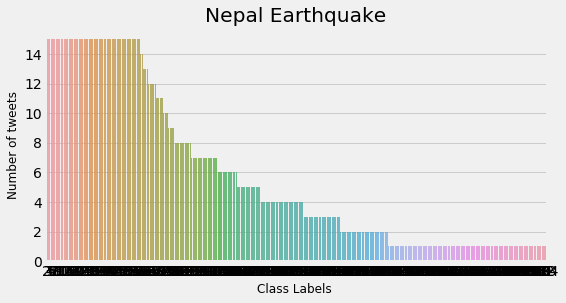

In [220]:
x=df['num_tag'].value_counts()
y=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(y.index, x.values, alpha=0.8)
plt.title("Nepal Earthquake")
plt.ylabel('Number of tweets', fontsize=12)
plt.xlabel('Class Labels ', fontsize=12);

<h3>Loading GloVe vectors:</h3>
<p> <b>NOTE:</b> The GloVe vectors I am using in this notebook is trained on tweet data. Possible improvement can be seen if vectors trained on relevant data is used for classificaton.</p>

In [124]:
embeddings_index = {}
f = open('glove.twitter.27B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


<h3>LSTM network:</h3>
<ul>
<li>Create the LSTM network structure using Keras with TensorFlow as backend.</li>
<li>Feed the data represented using GloVe vectors</li>
<li>Train the network and use validation set to tune hyperparemeters</li>
<li>Check accuracy on test data</li>
</ul>

In [125]:
EMBEDDING_DIM = 200 # how big is each word vector

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [126]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [137]:
from keras.layers import Bidirectional, GlobalMaxPool1D,Conv1D
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation

from keras.models import Model


inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)
x = Bidirectional(LSTM(500, return_sequences=True, dropout=0.5, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(305, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [221]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=30, batch_size=64);

Train on 1120 samples, validate on 350 samples
Epoch 1/20
1120/1120 [==============================] - 38s 34ms/step - loss: 5.3045 - acc: 0.0134 - val_loss: 5.1538 - val_acc: 0.0229
Epoch 2/20
1120/1120 [==============================] - 38s 34ms/step - loss: 5.2493 - acc: 0.0107 - val_loss: 5.1245 - val_acc: 0.0229
Epoch 3/20
1120/1120 [==============================] - 38s 34ms/step - loss: 5.2098 - acc: 0.0170 - val_loss: 5.0896 - val_acc: 0.0171
Epoch 4/20
1120/1120 [==============================] - 38s 34ms/step - loss: 5.1350 - acc: 0.0205 - val_loss: 5.1069 - val_acc: 0.0314
Epoch 5/20
1120/1120 [==============================] - 38s 34ms/step - loss: 5.1210 - acc: 0.0170 - val_loss: 5.0622 - val_acc: 0.0257
Epoch 6/20
1120/1120 [==============================] - 38s 34ms/step - loss: 5.0685 - acc: 0.0179 - val_loss: 5.0505 - val_acc: 0.0343
Epoch 7/20
1120/1120 [==============================] - 38s 34ms/step - loss: 5.0379 - acc: 0.0188 - val_loss: 5.0326 - val_acc: 0.0257
E

In [222]:
preds = model.predict(x_test)

In [263]:
temp = preds.copy()
temp[temp>=0.4] = 1
temp[temp<0.4] = 0

In [257]:
listm = []
for j in preds:
    max = -9999999
    for i in j:
        if i>max:
            max = i
    listm.append(max)

In [264]:
correct = 0
for i in range(len(temp)):
    a = temp[i]
    b = y_test[i]
    s = np.dot(a,b)
    correct = correct + s

acc = (correct*100)/len(temp)

In [265]:
print "accuraacy of test data: " + str(acc)

accuraacy of test data: 44.285714285714285


<b>NOTE:</b> 
<ul>
<li>Since the annotation for lables are done manually and more than one annotation may qualify as correct label, accuracy of the algorithm is determinded by the following way.
</li>
<li>LSTM network outputs a 303(total number of possible tags) length vector for each test data which consists of its confidence score about the question belonging to a particular tag. For accuracy calculation, tags which are outputted by the network with a confidence score >40% are considered as possible candidates and if the actual tag matches with any of them, it is considered to be success.</li>
<li>Since deep neural networks typically require huge amount of data and the given data set is really small, the network is expected to underperform due to various reasons.</li>
<li>There are various hyperparameters in this implementation and those can be further tuned to bring up the accuracy.</li>